### **LUNAR LANDER DDQN**

This is a naive version vectorized of the DDQN Algorithm for the Lunar Lander env <br>

The Double DQN (DDQN) uses two networks one as a target and one as the trained network <br>

The target network is a copy of the online network that is updated less frequently, <br>
and is used to generate the target values for the Q-learning update

It includes a soft update of the weights, instead of substituting the weights between the networks it blends them together using a Polyak averaging This was an improvement on the pure DDQN algorithm <br>

It takes some time but with some hyperparameter optimization you'll converge around 231 episodes <br>

There is room for improvement This version took 800 minutes in a slow computer with several versions running in parallel, try to stabilize training and make it faster to converge



In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal, HeUniform
from tensorflow.keras.regularizers  import L1L2, L2
import time
from PIL import Image

# Activate GPU
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

# Use mixed-precision training for faster computations on supported GPUs
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


# Enable XLA (Accelerated Linear Algebra) optimization
tf.config.optimizer.set_jit(True)
import sys
sys.stderr = open('err.txt', 'w')

Using device: 0, name: NVIDIA T600 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5


In [2]:
# Environment setup
env = gym.make('LunarLander-v3')
state_size = env.observation_space.shape[0]  # 8 state variables
action_size = env.action_space.n             # 4 discrete actions
tf.random.set_seed(221)                      # For reproducibility

#### **Hyperparameters**

In [14]:
ROLLING_WINDOW=20

learning_rate = 0.0005      
gamma = 0.99
batch_size = 64             
epsilon_start = 1.0
epsilon_min = 0.01
epsilon_decay = 0.99        # closer to 1 : more exploration    
num_episodes = 1000
buffer_capacity = 100000    # 100000
solved_threshold = 200
retrain_steps = 15          # We copy weights every retrain_steps 15
tau = 0.05                  # Soft update, it is high for long retrain periods. Small for short retrain 0.15

#### **Replay Buffer Functions (in-out)**

In [4]:
# Replay buffer
replay_buffer = deque(maxlen=buffer_capacity)

# Add experience to replay buffer
def store_experience(state, action, reward, next_state, done):
    replay_buffer.append((state, action, reward, next_state, done))

# Sample experiences from the replay buffer
def sample_experiences(batch_size):
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
    batch = [replay_buffer[i] for i in indices]
    states, actions, rewards, next_states, dones = zip(*batch)
    return (
        np.vstack(states),
        np.array(actions),
        np.array(rewards),
        np.vstack(next_states),
        np.array(dones, dtype=np.float32)
    )

#### **Neural Network**

In [5]:
# Build the neural network
def build_model(state_size, action_size):
    model = Sequential([
        Dense(128, activation='relu',  kernel_initializer=HeUniform(), input_shape=(state_size,)),
        Dense(64,  kernel_initializer=HeUniform(), activation='relu'),
        Dense(32,  kernel_initializer=HeUniform(), activation='relu'),
        Dense(action_size, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='huber')
    return model


In [6]:
def build_model(state_size, action_size):
    inputs = Input(shape=(state_size,))
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(action_size, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
#    model.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mse') # to improve train stability
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

#### **Support Functions**

In [7]:
# Soft update function for the target network
def soft_update(model, target_model, tau):
    """ Soft Update using Polyak Optimization """
    target_weights = target_model.get_weights()
    model_weights = model.get_weights()
    new_weights = [
        tau * mw + (1 - tau) * tw for mw, tw in zip(model_weights, target_weights)
    ]
    target_model.set_weights(new_weights)
    
def hard_update(model, target_model):
    """Hard Update: Directly copies weights from model to target_model"""
    target_model.set_weights(model.get_weights())


# Double DQN target calculation
def experience_replay_with_ddqn(model, target_model, batch_size, gamma, tau, step, episode):
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)

    # Predict Q-values for next states using both networks
    next_q_values = model.predict(next_states, verbose=0)
    best_actions = np.argmax(next_q_values, axis=1)
    target_q_values = target_model.predict(next_states, verbose=0)

    # Update Q-values using Double DQN formula
    targets = rewards + gamma * target_q_values[np.arange(batch_size), best_actions] * (1 - dones)

    # Update main Q-network
    q_values = model.predict(states, verbose=0)
    q_values[np.arange(batch_size), actions] = targets
    model.fit(states, q_values, epochs=1, verbose=0)

    # Apply soft update to target network
    if step % retrain_steps == 0:   
        soft_update(model, target_model, tau)


#### **Training Phase**

In [8]:
# Initialize models
model = build_model(state_size, action_size)
target_model = build_model(state_size, action_size)
target_model.set_weights(model.get_weights())             # Sync target network initially
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,620 (45.39 KB)

 Trainable params: 11,620 (45.39 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Training loop
epsilon = epsilon_start
episode_rewards = []
rolling_avg_rewards = []

start_time = time.time()

for episode in range(num_episodes):
    
    state, _ = env.reset()
    state  = np.reshape(state, [1, state_size])
    total_reward = 0
    done = False
    terminated = False
    truncated = False
    step = 0
    while True:
        
        # Epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.randint(action_size)             # Explore
        else:
            action_vals = model.predict(state, verbose=0)
            action = np.argmax(action_vals[0])                  # Exploit

        # Perform action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated 
        next_state = np.reshape(next_state, [1, state_size])
              
        total_reward += reward

        # Store experience
        store_experience(state, action, reward, next_state, done)

        # Update state
        state = next_state

        # Train using experience replay
        experience_replay_with_ddqn(model, target_model, batch_size, gamma, tau, step, episode)
        step = step + 1
        
        if done:
            break
        if step > 1000:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Record reward
    episode_rewards.append(total_reward)
    rolling_avg = np.mean(episode_rewards[-ROLLING_WINDOW:])
    rolling_avg_rewards.append(rolling_avg)

    # Print progress
    print(f"Episode: {episode+1:3}/{num_episodes}, Reward: {total_reward:+7.2f}, "
                  f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:7.2f}, Steps: {step:4} Terminated: {done} ")

    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        model.save("lunarlander_ddqn_model1.keras")
        break

end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")

Episode:   1/1000, Reward: -280.85, Epsilon: 0.99, Rolling Avg: -280.85, Steps:  104 Terminated: True 
Episode:   2/1000, Reward: -267.39, Epsilon: 0.98, Rolling Avg: -274.12, Steps:  103 Terminated: True 
Episode:   3/1000, Reward: -234.98, Epsilon: 0.97, Rolling Avg: -261.07, Steps:   95 Terminated: True 
Episode:   4/1000, Reward: -197.47, Epsilon: 0.96, Rolling Avg: -245.17, Steps:  106 Terminated: True 
Episode:   5/1000, Reward:  -91.79, Epsilon: 0.95, Rolling Avg: -214.50, Steps:  108 Terminated: True 
Episode:   6/1000, Reward: -207.89, Epsilon: 0.94, Rolling Avg: -213.40, Steps:  134 Terminated: True 
Episode:   7/1000, Reward: -291.02, Epsilon: 0.93, Rolling Avg: -224.48, Steps:  113 Terminated: True 
Episode:   8/1000, Reward:  -57.13, Epsilon: 0.92, Rolling Avg: -203.56, Steps:   75 Terminated: True 
Episode:   9/1000, Reward:  -91.65, Epsilon: 0.91, Rolling Avg: -191.13, Steps:  114 Terminated: True 
Episode:  10/1000, Reward: -147.86, Epsilon: 0.90, Rolling Avg: -186.80, 

Episode:  81/1000, Reward:  -26.15, Epsilon: 0.44, Rolling Avg:  -50.69, Steps:  452 Terminated: True 
Episode:  82/1000, Reward:  +22.16, Epsilon: 0.44, Rolling Avg:  -46.61, Steps:  142 Terminated: True 
Episode:  83/1000, Reward:  -70.26, Epsilon: 0.43, Rolling Avg:  -47.94, Steps:  522 Terminated: True 
Episode:  84/1000, Reward:  -90.32, Epsilon: 0.43, Rolling Avg:  -49.45, Steps:  212 Terminated: True 
Episode:  85/1000, Reward:  -48.05, Epsilon: 0.43, Rolling Avg:  -51.48, Steps:  156 Terminated: True 
Episode:  86/1000, Reward:  -65.73, Epsilon: 0.42, Rolling Avg:  -52.17, Steps:  116 Terminated: True 
Episode:  87/1000, Reward:  -85.06, Epsilon: 0.42, Rolling Avg:  -52.93, Steps:  134 Terminated: True 
Episode:  88/1000, Reward:  -95.79, Epsilon: 0.41, Rolling Avg:  -55.44, Steps:   98 Terminated: True 
Episode:  89/1000, Reward:  -45.42, Epsilon: 0.41, Rolling Avg:  -58.26, Steps: 1001 Terminated: False 
Episode:  90/1000, Reward: -100.96, Epsilon: 0.40, Rolling Avg:  -58.36,

Episode: 161/1000, Reward: +122.82, Epsilon: 0.20, Rolling Avg:  118.97, Steps: 1001 Terminated: False 
Episode: 162/1000, Reward: +149.70, Epsilon: 0.20, Rolling Avg:  120.66, Steps: 1001 Terminated: False 
Episode: 163/1000, Reward: +139.03, Epsilon: 0.19, Rolling Avg:  120.76, Steps: 1001 Terminated: False 
Episode: 164/1000, Reward:  +96.72, Epsilon: 0.19, Rolling Avg:  125.19, Steps: 1001 Terminated: False 
Episode: 165/1000, Reward: +111.22, Epsilon: 0.19, Rolling Avg:  123.99, Steps: 1001 Terminated: False 
Episode: 166/1000, Reward: +216.36, Epsilon: 0.19, Rolling Avg:  126.89, Steps:  685 Terminated: True 
Episode: 167/1000, Reward:  -28.40, Epsilon: 0.19, Rolling Avg:  119.08, Steps:  142 Terminated: True 
Episode: 168/1000, Reward:  +96.37, Epsilon: 0.18, Rolling Avg:  115.37, Steps: 1001 Terminated: False 
Episode: 169/1000, Reward: +134.75, Epsilon: 0.18, Rolling Avg:  116.35, Steps: 1001 Terminated: False 
Episode: 170/1000, Reward: +271.71, Epsilon: 0.18, Rolling Avg:  1

#### **Learning Plot and Episode Rewards**

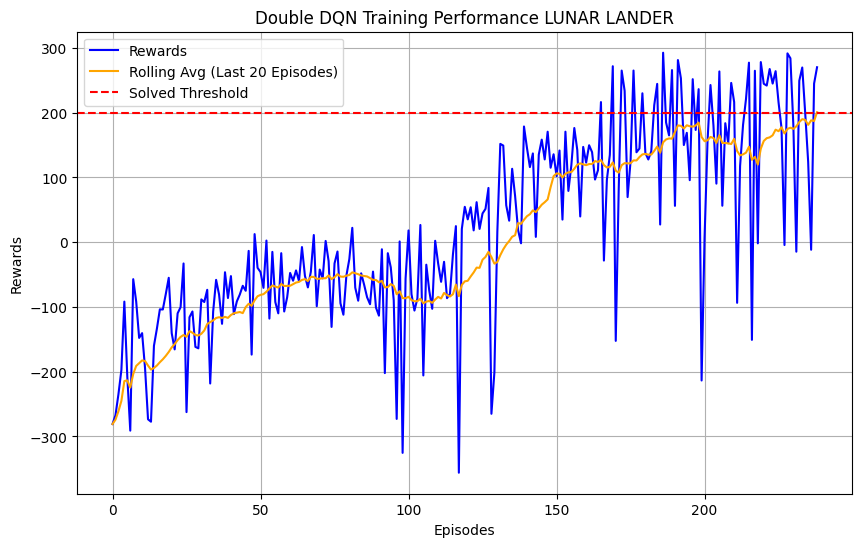

In [16]:
# Plot rewards with rolling average
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last '+str(ROLLING_WINDOW)+' Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('Double DQN Training Performance LUNAR LANDER')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

#### **Test Results**

In [11]:
# Testing for 10 episodes
start_time = time.time()

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    while True:
        # Use the trained model for testing
        action_vals = model.predict(state, verbose=0)  # Predict action values
        action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1

        if done:
            print(f"Test Episode: {e_test + 1}/50, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")


Test Episode: 1/50, Reward: 261.37, Steps: 184
Test Episode: 2/50, Reward: 157.48, Steps: 518
Test Episode: 3/50, Reward: 261.99, Steps: 368
Test Episode: 4/50, Reward: 240.03, Steps: 190
Test Episode: 5/50, Reward: 313.06, Steps: 208
Test Episode: 6/50, Reward: 258.22, Steps: 218
Test Episode: 7/50, Reward: 296.35, Steps: 241
Test Episode: 8/50, Reward: 274.64, Steps: 220
Test Episode: 9/50, Reward: 263.89, Steps: 200
Test Episode: 10/50, Reward: 271.10, Steps: 194
Testing completed in 3.71 minutes


In [17]:
# Test the trained agent with video rendering
# This code is very convenient if you are using colab
env = gym.make('LunarLander-v3', render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    action_vals = model.predict(state, verbose=0)  # Predict action values
    action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

    next_state, reward, done, _, _ = env.step(action)
    frames.append(env.render())  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='lunarlander_ddqn1.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename="LUNARLANDER_DDQN.gif")


Rendered Test Episode Reward: 290.56
Saved GIF to: ./LUNARLANDER_DDQN.gif


In [13]:
import session_info
session_info.show(html=False)

-----
PIL                 11.0.0
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Jan 17 2025, 18:03:48) [GCC 13.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-02-02 01:25
